# Moving Least Squares and Marching Squares

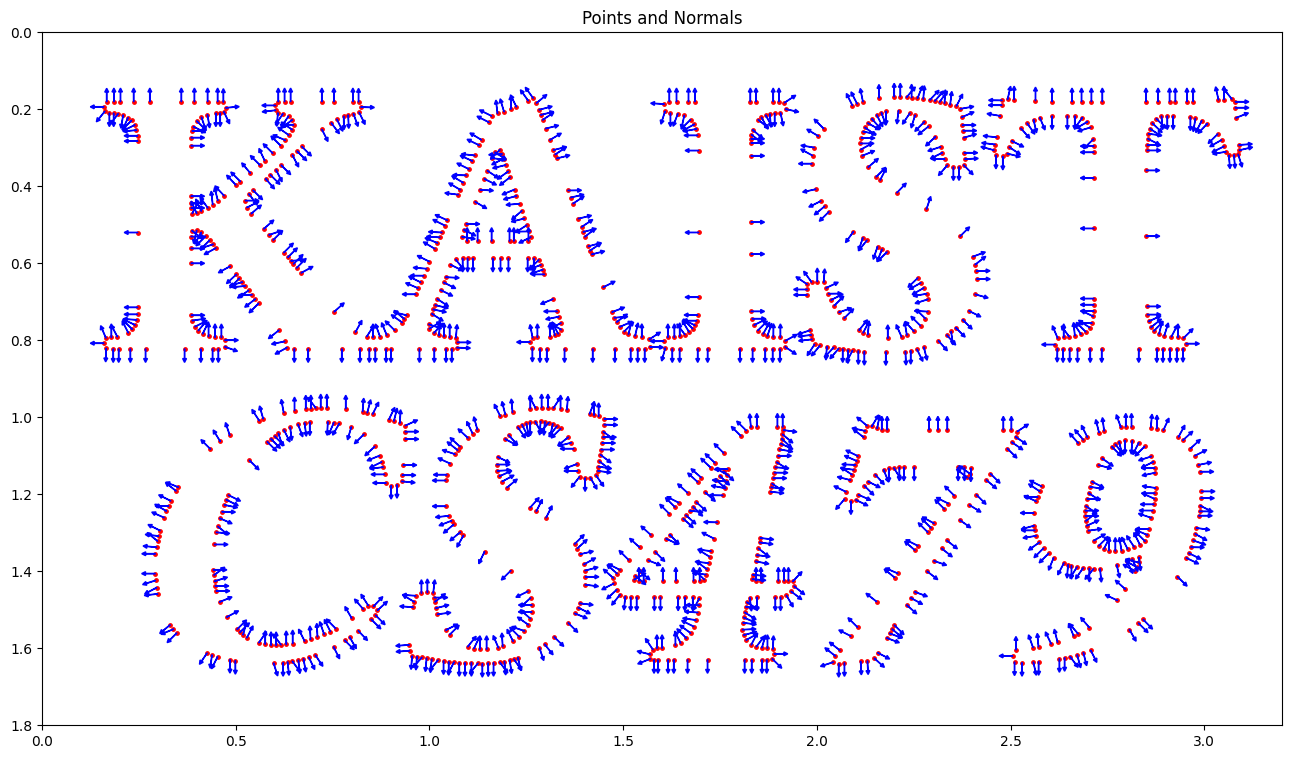

In [424]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle

with open("data/input.pkl", "rb") as f: points, normals = pickle.load(f);
points, normals = torch.from_numpy(points), torch.from_numpy(normals);

with open("data/gt.pkl", "rb") as f: gt_values, gt_contour = pickle.load(f);
gt_values, gt_contour = torch.from_numpy(gt_values), torch.from_numpy(gt_contour);

plt.figure(figsize=(16, 9))
plt.scatter(points[:, 0], points[:, 1], s = 6.0, color = "r");

for i in range(len(normals)):
    p = points[i]
    n = normals[i] / 40.0  # Scale normal for better visualization
    plt.arrow(p[0], p[1], n[0], n[1], color='b', head_width=0.01, head_length=0.01)

plt.title("Points and Normals")
xlim, ylim = [0.0, 3.2], [0.0, 1.8];
plt.xlim(xlim);
plt.ylim(ylim);
plt.gca().invert_yaxis()
plt.show()

---
# Task 1: Approximation of Implicit Function from a Point Cloud

In this assignment, we use **Implicit Moving Least Squares (IMLS)** to approximate an implicit function $f(\mathbf{x})$ given a set of points $\{\mathbf{p}_i\}$ and their associated normals $\{\mathbf{n}_i\}$. The IMLS method computes $f(\mathbf{x})$ by a **weighted average** of local contributions from each neighbor point:

$$
f(\mathbf{x}) 
\;=\;
\frac{\displaystyle \sum_{i} w_i \,\bigl(\mathbf{x} - \mathbf{p}_i\bigr)^{T} \,\mathbf{n}_i}
     {\displaystyle \sum_{i} w_i}.
$$


### Weight Function

To capture local influence, each point $\mathbf{p}_i$ contributes a weight $\mathbf{w}_i$. You should use a Gaussian‐like kernel:

$$
w_i 
\;=\; 
\frac{1}{k_i} \exp\!\Bigl(\!-\tfrac{\|\mathbf{x} - \mathbf{p}_i\|^2}{\epsilon^2}\Bigr),
$$

where

- $\epsilon$ is a *radius* parameter controlling the falloff of influence (sometimes referred to as the “ball radius”). We use 0.01.
- $k_i$ is the number of neighbor points within $\epsilon$ of $\mathbf{p}_i$.
---

In [425]:
eps = 1e-2;
dist = torch.cdist(points, points); # points의 모든점과 모든점 사이 거리를 구하는 함수. [1200, 2] - > [1200, 1200]. 1200개의 x, y 좌표가 1200 * 1200 이 됨. 
k = torch.sum(dist < eps, dim = 1); # 밀도 보정을 위한 항이다. p_i가 있는 지역이 고밀도이면 전체 값에 너무 영향을 미치므로 weight를 줄여준다. 정규화 항이라고 볼 수 있다. 

In [ ]:
def get_f_value(x):
    '''
        Input
            x: torch.tensor [#query points, 2(dimension)]
        Output
            f_x: torch.tensor [#query points,]
        
        Implement the approximation of the Implicit Function
        using Implicit Moving Least Squares method.
    '''

    # ======================= TODO ===========================
    # DO NOT MODIFY OUTSIDE

    dist_qp = torch.cdist(x, points)
    
    weights = torch.exp(-(dist_qp**2) / (eps**2))      # [Q, 1200]
    weights = weights / (k.unsqueeze(0))               # [Q, 1200] 형태로 맞춰주기 위해 k unsqueeze 하고 broadcasting 됨
    
    # numerator
    x_expanded = x.unsqueeze(1)
    p_expanded = points.unsqueeze(0)
    n_expanded = normals.unsqueeze(0)

    diff = x_expanded - p_expanded                     # [Q, 1200, 2]
    dot_term = torch.sum(diff * n_expanded, dim = 2)   # 내적을 표현하기 위해 dim=2 로 sum 해줌 [Q, 1200]
    numerator = torch.sum(weights * dot_term, dim=1)   # [Q]

    # denominator
    denominator = torch.sum(weights, dim=1)            # [Q]

    f_x = numerator / denominator

    # f_x 안에 nan 값이 있는것으로 판명되는데, denominator가 너무 작아서 무한으로 터지는가보다. 즉 dist_qp가 너무 크기에 그런것 같은데 이것을 어찌해야하나.
    
    # DO NOT MODIFY OUTSIDE
    # ======================= TODO ===========================
    return f_x

### Visualization of the Implicit Function ($Look\ at\ the\ title\ of\ the\ plot\ for\ Top\ 90\%\ Error$)

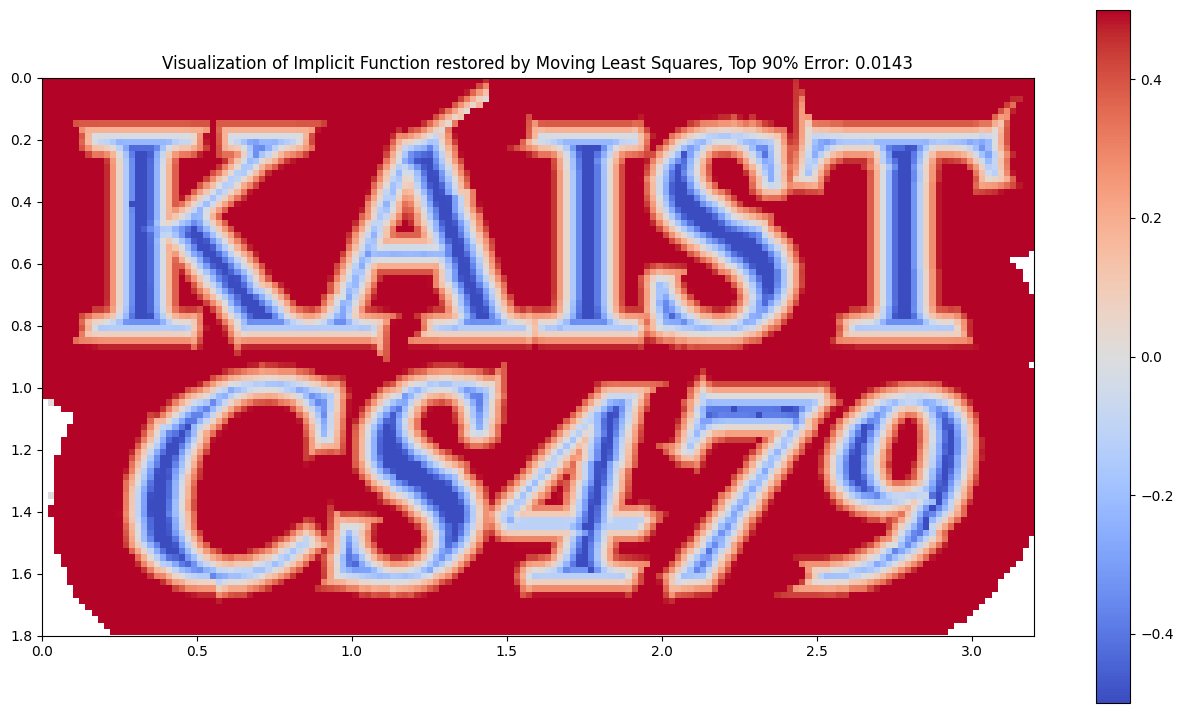

In [449]:
x = np.linspace(*xlim, 160);
y = np.linspace(*ylim, 90);
X, Y = np.meshgrid(x, y);
coord = torch.from_numpy(np.stack((X.reshape(-1), Y.reshape(-1)), axis = 1));
Z = get_f_value(coord).reshape(X.shape);
error = torch.sort(torch.abs(gt_values - Z).reshape(-1))[0];


plt.figure(figsize=(16, 9));
plt.imshow(torch.clamp(Z * 10.0, -0.5, 0.5), extent=[*xlim, *ylim], origin='lower', cmap='coolwarm');
plt.title("Visualization of Implicit Function restored by Moving Least Squares, Top 90% Error: {:.4f}".format(error[int(error.shape[0] * 0.9)]));
plt.colorbar()
plt.xlim(xlim);
plt.ylim(ylim);
plt.gca().invert_yaxis();
plt.show();

In [450]:
# Step-by-step NaN debug

with torch.no_grad():

    dist_qp = torch.cdist(coord, points)
    print("dist_qp NaN:", torch.isnan(dist_qp).any())

    weights = torch.exp(-(dist_qp**2) / (eps**2))
    print("weights NaN:", torch.isnan(weights).any(), 
          "min:", weights.min().item(), "max:", weights.max().item())

    weights_norm = weights / k.unsqueeze(0)
    print("weights_norm NaN:", torch.isnan(weights_norm).any(),
          "min:", weights_norm.min().item(), "max:", weights_norm.max().item())

    x_exp = coord.unsqueeze(1)
    p_exp = points.unsqueeze(0)
    n_exp = normals.unsqueeze(0)

    diff = x_exp - p_exp
    dot_term = torch.sum(diff * n_exp, dim=2)
    print("dot_term NaN:", torch.isnan(dot_term).any())

    numerator = torch.sum(weights_norm * dot_term, dim=1)
    denominator = torch.sum(weights_norm, dim=1)

    print("numerator NaN:", torch.isnan(numerator).any(), 
          "denominator NaN:", torch.isnan(denominator).any())
    print("denominator min:", denominator.min().item())

f_x = numerator / denominator
print("f_x NaN:", torch.isnan(f_x).any())

dist_qp NaN: tensor(False)
weights NaN: tensor(False) min: 0.0 max: 0.9964444153617869
weights_norm NaN: tensor(False) min: 0.0 max: 0.995505197765742
dot_term NaN: tensor(False)
numerator NaN: tensor(False) denominator NaN: tensor(False)
denominator min: 0.0
f_x NaN: tensor(True)


---
# Task 2: Marching Squares

**Marching Squares** is a **2D** algorithm to extract a contour (or iso‐curve) from a scalar field $F(\mathbf{x})$. It is the 2D analogue of the well‐known **Marching Cubes** algorithm in 3D.

1. **Grid the Domain**  
   - You overlay a uniform grid over the bounding box that contains your data.  
   - At each grid cell corner \((i, j)\), you evaluate \(F(i, j)\).

2. **Cell Classification**  
   - For each cell (which has 4 corners), you check if each corner’s value is above or below the iso‐level (often \(F = 0\)).  
   - This gives you a pattern of bits (e.g., 0 for below, 1 for above), which indicates which edges of the cell the contour will cross.

3. **Edge Interpolation**  
   - If two corners differ in sign, the contour must pass somewhere between them.  
   - You compute the intersection point by linearly interpolating along the edge:

     $$
     \mathbf{p} \;=\; \mathbf{p}_1 \;+\; \alpha\,(\mathbf{p}_2 - \mathbf{p}_1),
     \quad \text{where} \quad
     \alpha \;=\; \frac{\,0 - F(\mathbf{p}_1)\,}{F(\mathbf{p}_2) \;-\; F(\mathbf{p}_1)}.
     $$

4. **Connecting Segments**  
   - Based on which edges are intersected, you connect the intersection points within each cell to form small line segments.  
   - These line segments across all cells piece together to form continuous contours.  
   - Special **ambiguous cases** (where a cell’s corners give four intersections) require disambiguation rules so that the lines connect consistently.

5. **Outcome**  
   - The final result is a collection of line segments or polylines forming the approximate curve $F(\mathbf{x})= 0$.  
   - Marching Squares is **straightforward**, **efficient**, and widely used in scientific visualization and image processing.

---


In [451]:
points_to_offset = torch.tensor([
    [0, 0], # location of point 0    of cell at (y, x): (y, x) + (0, 0)
    [0, 1], # location of point 1    of cell at (y, x): (y, x) + (0, 1)
    [1, 1], # location of point 2    of cell at (y, x): (y, x) + (1, 1)
    [1, 0]  # location of point 3    of cell at (y, x): (y, x) + (1, 0)
], dtype = torch.int64);

edge_to_points = torch.tensor([
    [0, 1], # edge 0:  point 0 and point 1
    [1, 2], # edge 1:  point 1 and point 2
    [2, 3], # edge 2:  point 2 and point 3
    [3, 0]  # edge 3:  point 3 and point 0
], dtype = torch.int64);



# ======================= TODO ===========================
# DO NOT MODIFY OUTSIDE
'''
    Fill out the table "case_to_edges".
    
    case 0011 (binary) means that grid points 2 and 3 (see "points_to_offset" for indexing)  # 여기 표기 잘못됨 0011이면 point 0,1 이여야 함
    out of 4 grid points of a grid cell have larger values than the level(=0.0).
    
    If the "case_to_edges" element for a case is given by [[0, 1], [-1, -1]],
    then for the first element [0, 1], it will find the 0-level points
    along the edge 0 and edge 1 (see "edge_to_points" for indexing),
    and draw a line between the points found.
    Also, for the second element [-1, -1], it will skip to draw a line segment in this case.

    Note that you don't have to address the ambiguous cases in this assignment.
'''

case_to_edges = torch.tensor([
    [[-1, -1], [-1, -1]], # case 0   0000
    [[ 0,  3], [-1, -1]], # case 1   1000 (P0)
    [[ 0,  1], [-1, -1]], # case 2   0100 (P1)
    [[ 1,  3], [-1, -1]], # case 3   1100 (P0, P1)
    [[ 1,  2], [-1, -1]], # case 4   0010 (P2)
    [[ 0,  1], [2, 3]], # case 5   1010 (P0, P2) - Ambiguous, selected one segment (0 to 1)
    [[ 0,  2], [-1, -1]], # case 6   0110 (P1, P2)
    [[ 2,  3], [-1, -1]], # case 7   1110 (P0, P1, P2)
    [[ 2,  3], [-1, -1]], # case 8   0001 (P3)
    [[ 0,  2], [-1, -1]], # case 9   1001 (P0, P3)
    [[ 0,  3], [1, 2]], # case 10  0101 (P1, P3) - Ambiguous, selected one segment (0 to 3)
    [[ 1,  2], [-1, -1]], # case 11  1101 (P0, P1, P3)
    [[ 1,  3], [-1, -1]], # case 12  0011 (P2, P3)
    [[ 0,  1], [-1, -1]], # case 13  1011 (P0, P2, P3) - Inverted of case 2
    [[ 0,  3], [-1, -1]], # case 14  0111 (P1, P2, P3) - Inverted of case 1
    [[-1, -1], [-1, -1]]  # case 15  1111
], dtype = torch.int64);

# DO NOT MODIFY OUTSIDE
# ======================= TODO ===========================

In [ ]:
def marching_squares(data, level = 0.0):
    Ny, Nx = data.shape
    # sdf value for (y, x): data[y, x]
    grid_index = torch.arange(Ny * Nx).reshape(Ny, Nx);
    cell_index = grid_index[:-1, :-1]; # Ny-1 x Nx-1
    cell_coord = torch.stack((cell_index // Nx, cell_index % Nx), dim = 2); # 각 좌표들을 grid 로 표현하기 위해서 x축값으로 나눈 몫과 나머지들을 사용


    cell_cases = torch.zeros_like(cell_index); # Ny-1 x Nx-1
    for case, offset in zip([1, 2, 4, 8], points_to_offset):
        cell_case = (data[cell_coord[..., 0] + offset[0], cell_coord[..., 1] + offset[1]] > level).to(cell_index.dtype);
        cell_cases += case * cell_case; # 각 cell마다 어떤 case를 가지는지 기록. 어떤 case 인지에 따라 segment 모양이 달라진다.

    contour = [];
    for edgei in range(2):
        edges = case_to_edges[cell_cases, edgei]; # Ny-1 x Nx-1 x 2
        exist = edges[..., 0] != -1; # Ny-1 x Nx-1.  segment 존재하는 index 찾는 용도
        edges = edges[exist]; # B x 2.  B : segment가 존재하는 cell의 수. 즉 segment가 존재하는 edge 들로만 이루어짐
        cell_crd = cell_coord[exist].view(-1, 1, 1, 2); # B x 1 x 1 x 2
        coords_ = points_to_offset[edge_to_points[edges]] + cell_crd # B x 2 x 2 x 2. segment 있는 cell(B)의 2개의 edge의 2개의 point의 각 좌표 
        values_ = data[coords_[..., 0], coords_[..., 1]]; # B x 2 x 2. segment가 존재하는 cell들의 point들의 sdf 값

        ts_ = (level - values_[..., 0]) / (values_[..., 1] - values_[..., 0]); # B x 2. 위에서 구한 points들의 sdf 값과 sdf가 0인 값 사이 거리 비율을 구하고
        ts_ = torch.clamp(ts_.unsqueeze(2), 0.0, 1.0); # B x 2 x 1
        points_ = coords_[:, :, 0] + ts_ * (coords_[:, :, 1] - coords_[:, :, 0]); # B x 2 x 2. 그 비율을 통해 points 보간법 이용해서 실제 만나는 점 좌표를 구함.
        points_ = torch.flip(points_, [-1]);
        scale = torch.tensor([[[(xlim[1] - xlim[0]) / Nx, (ylim[1] - ylim[0]) / Ny]]]);
        start = torch.tensor([[[xlim[0], ylim[0]]]]);
        contour.append(start + points_ * scale);
    
    contour = torch.cat(contour, dim = 0);
    return contour;

contours = marching_squares(Z);

torch.Size([1967, 2, 2])
tensor([[[ 0.0186, -0.0015],
         [-0.0015,  0.0166]],

        [[ 0.0183, -0.0020],
         [-0.0015,  0.0186]],

        [[ 0.0182, -0.0020],
         [-0.0020,  0.0183]],

        ...,

        [[ 0.2589,     nan],
         [    nan,  0.2588]],

        [[ 0.2638,     nan],
         [    nan,  0.3333]],

        [[ 0.2638,     nan],
         [    nan,  0.2638]]], dtype=torch.float64)
torch.Size([0, 2, 2])
tensor([], size=(0, 2, 2), dtype=torch.float64)


### Visualization of the Contour ($Look\ at\ the\ title\ of\ the\ plot\ for\ the\ Metrics$)

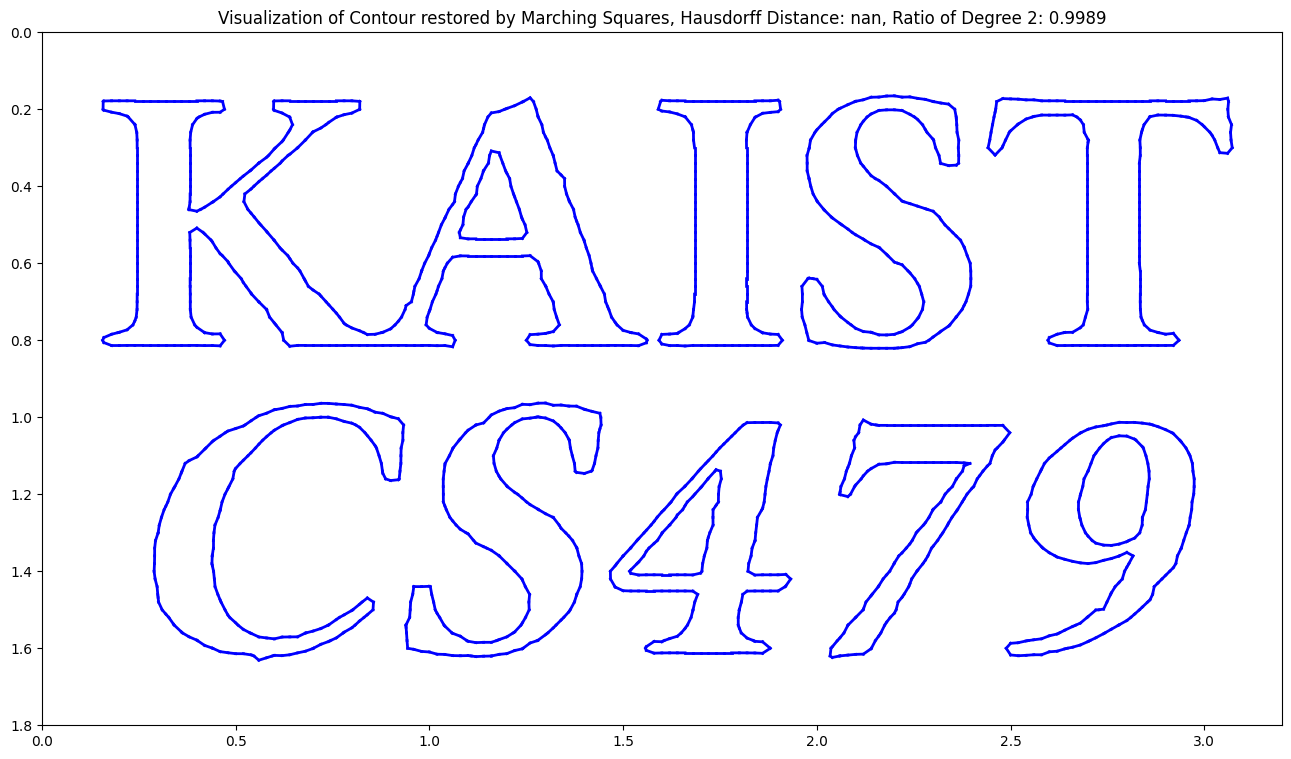

In [453]:
def point_to_segment_distance(points, seg_start, seg_end):
    seg_vec = seg_end - seg_start;  # [M, D]
    seg_len_sq = torch.sum(seg_vec**2, dim=-1, keepdim=True);  # [M, 1]
    
    p_vec = points[:, None, :] - seg_start[None, :, :];  # [N, M, D]
    proj = torch.sum(p_vec * seg_vec, dim=-1, keepdim=True) / seg_len_sq;  # [N, M, 1]
    proj = torch.clamp(proj, 0, 1);  # Clamp to segment [0, 1]
    
    closest_points = seg_start[None, :, :] + proj * seg_vec[None, :, :];  # [N, M, D]
    dists = torch.norm(points[:, None, :] - closest_points, dim=-1);  # [N, M]
    return dists;

def hausdorff_distance(set1, set2):
    start1, end1 = set1[:, 0, :], set1[:, 1, :];  # [N, D]
    start2, end2 = set2[:, 0, :], set2[:, 1, :];  # [M, D]

    min_d1 = torch.min(torch.minimum(point_to_segment_distance(start1, start2, end2),
                                     point_to_segment_distance(end1, start2, end2)),
                       dim=1)[0];  # Min for each row [N]
    min_d2 = torch.min(torch.minimum(point_to_segment_distance(start2, start1, end1),
                                     point_to_segment_distance(end2, start1, end1)),
                       dim=1)[0];  # Min for each row [M]

    directed_H1 = torch.max(min_d1);  # A -> B
    directed_H2 = torch.max(min_d2);  # B -> A
    return torch.max(directed_H1, directed_H2).item();

def degree2_ratio(contours):
    contour_ = contours.clone(); contour_ = (contours * 10000000).to(torch.int32);
    verts_unq = list(set([tuple(x.numpy().tolist()) for x in contour_.view(-1, 2)]));
    verts_idx = {vert: i for i, vert in enumerate(verts_unq)};

    V = len(verts_unq);
    degree = torch.zeros((V,), dtype = torch.int32);
    for vert0, vert1 in contour_:
        idx0 = verts_idx[tuple(vert0.numpy().tolist())];
        idx1 = verts_idx[tuple(vert1.numpy().tolist())];
        degree[idx0] += 1; degree[idx1] += 1;
    return torch.sum(degree == 2).item() / V;

plt.figure(figsize=(16, 9));
for (x1, y1), (x2, y2) in contours:
    plt.plot([x1, x2], [y1, y2], 'b-', linewidth=2);
plt.title("Visualization of Contour restored by Marching Squares, Hausdorff Distance: {:.4f}, Ratio of Degree 2: {:.4f}".format(
    hausdorff_distance(contours, gt_contour), degree2_ratio(contours)));
plt.xlim(xlim);
plt.ylim(ylim);
plt.gca().invert_yaxis();
plt.show();